In [52]:
""" Bike Sharing Demand Kaggle competition (https://www.kaggle.com/competitions/bike-sharing-demand/overview) 
Given various external conditions like temperature, day of the week, etc., predict how many bikes are going to
be rented in the future for a given hour of a given day.

Information about the data tables:

datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
"""

' Bike Sharing Demand Kaggle competition (https://www.kaggle.com/competitions/bike-sharing-demand/overview) \nGiven various external conditions like temperature, day of the week, etc., predict how many bikes are going to\nbe rented in the future for a given hour of a given day.\n\nInformation about the data tables:\n\ndatetime - hourly date + timestamp  \nseason -  1 = spring, 2 = summer, 3 = fall, 4 = winter \nholiday - whether the day is considered a holiday\nworkingday - whether the day is neither a weekend nor holiday\nweather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy\n2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist\n3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds\n4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog \ntemp - temperature in Celsius\natemp - "feels like" temperature in Celsius\nhumidity - relative humidity\nwindspeed - wind speed\ncasual - number of non-registered user rentals initiated\n

In [53]:
%reset -f

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
import numpy as np

## 1. Data Cleaning & Exploratory Analysis

In [54]:
# load training data
data = pd.read_csv('./data/train.csv', index_col=0, parse_dates=True) # read 1st col as datetimeindex

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [56]:
data.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8


In [57]:
print(data.isna().sum())
print('The table contains no NaNs')

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
The table contains no NaNs


In [58]:
# create new feature: year, month, day of the week
data['year'] = data.index.year
data['month'] =  data.index.month
data['day'] =  data.index.dayofweek
data['hour'] =  data.index.hour

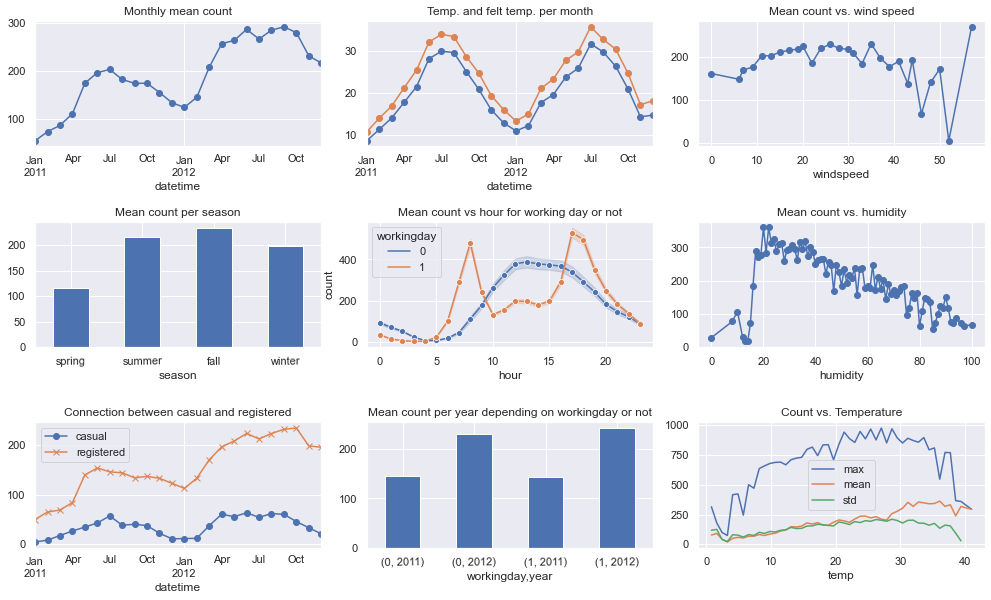

In [59]:
#EDA plots
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(14,8))
fig.tight_layout()

# avg. monthly rentals
data.resample('1m')['count'].mean().plot(ax=axes[0,0], marker='o')
ax=axes[0,0].set_title('Monthly mean count')
# avg. monthly temp and atemp
data.resample('1m')['temp'].mean().plot(ax=axes[0,1], marker='o')
data.resample('1m')['atemp'].mean().plot(ax=axes[0,1], marker='o')
ax=axes[0,1].set_title('Temp. and felt temp. per month')
# impact of windspeed on count
data.groupby('windspeed')['count'].mean().plot(ax=axes[0,2], marker='o')
ax=axes[0,2].set_title('Mean count vs. wind speed')
# histogram of rentals per season
data.groupby('season')['count'].mean().plot.bar(ax=axes[1,0], rot=1)
axes[1,0].set_xticklabels(['spring','summer','fall','winter'])  
ax=axes[1,0].set_title('Mean count per season')
# Mean count depending on holiday or not
sns.lineplot(data=data, x="hour", y="count", hue='workingday', marker='o', markers=True, ax=axes[1,1])
ax=axes[1,1].set_title('Mean count vs hour for working day or not')
# impact of humidity on count
data.groupby('humidity')['count'].mean().plot(ax=axes[1,2], marker='o')
ax=axes[1,2].set_title('Mean count vs. humidity')
# Mean count depending on workingday or not
data.groupby(['workingday','year'])['count'].mean().plot.bar(ax=axes[2,1], rot=1)
ax=axes[2,1].set_title('Mean count per year depending on workingday or not')
# correlation between casual and registered
data.resample('1m')['casual'].mean().plot(ax=axes[2,0], marker='o', legend=True)
data.resample('1m')['registered'].mean().plot(ax=axes[2,0], marker='x', legend=True)
ax=axes[2,0].set_title('Connection between casual and registered')
# avg. monthly count vs. temp.
data.groupby('temp')['count'].max().plot(ax=axes[2,2], legend=True, label='max')
data.groupby('temp')['count'].mean().plot(ax=axes[2,2], legend=True,  label='mean')
data.groupby('temp')['count'].std().plot(ax=axes[2,2], legend=True,  label='std')
ax=axes[2,2].set_title('Count vs. Temperature')

plt.subplots_adjust(hspace = 0.6)
plt.show()


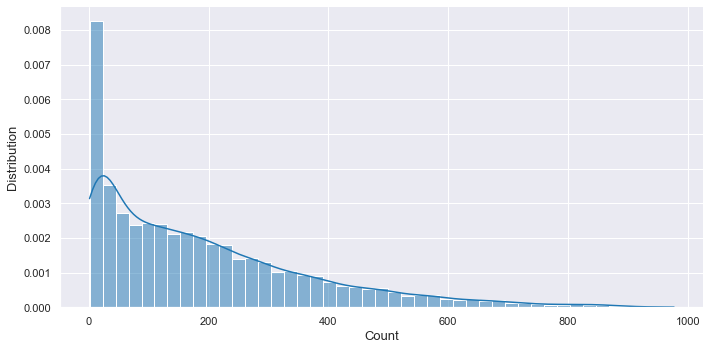

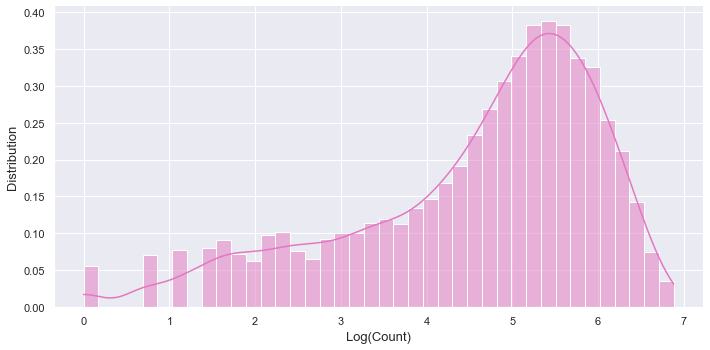

In [60]:
# total distribution of count
sns.displot(data["count"], kde=True, aspect=2, stat='density', color='tab:blue')
plt.xlabel('Count', fontsize=13)
plt.ylabel('Distribution', fontsize=13)

sns.displot(np.log(data["count"]), kde=True, aspect=2, stat='density', color='tab:pink')
plt.xlabel('Log(Count)', fontsize=13)
plt.ylabel('Distribution', fontsize=13)
plt.show()

In [61]:
""" Observations:
- temp and atemp (felt temp) are very closely correlated and one can be dropped
- the oscillating behaviour of large windspeeds should be smoothed
- season has a significant influence on bikes rented
- we can drop day and instead keep workingday as the combination workingday+hour has strong influence on count
- small oscillations in humidity should be smoothed
- the mean count is much higher in 2012 than 2011 -> year is an important feature
- registered + casual = count, therefore they need to be removed

- taking the log of the count gives a more normal distribution of the observed values
"""

' Observations:\n- temp and atemp (felt temp) are very closely correlated and one can be dropped\n- the oscillating behaviour of large windspeeds should be smoothed\n- season has a significant influence on bikes rented\n- we can drop day and instead keep workingday as the combination workingday+hour has strong influence on count\n- small oscillations in humidity should be smoothed\n- the mean count is much higher in 2012 than 2011 -> year is an important feature\n- registered + casual = count, therefore they need to be removed\n\n- taking the log of the count gives a more normal distribution of the observed values\n'

## 2. Feature Engineering

### 2.1 Feature Selection

In [62]:
# remove unnecessary features according to the observations above
data = data.drop(columns=['holiday', 'registered', 'casual', 'temp', 'day'], axis=1)

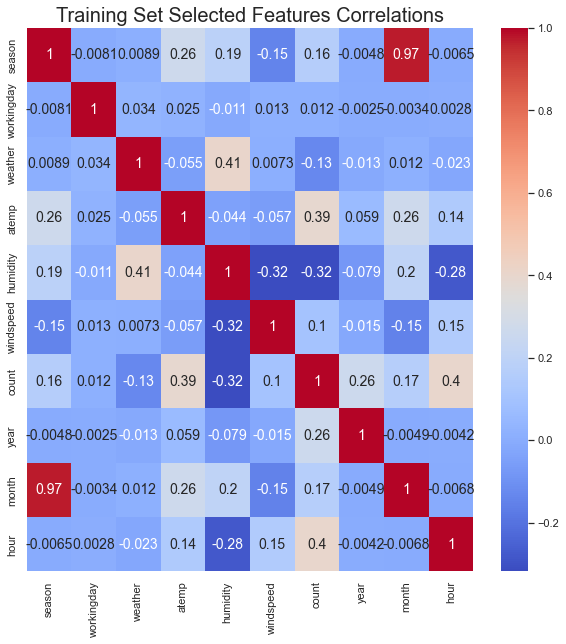

In [63]:
# feature correlation heatmap
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(data.corr(), annot=True, square=False, cmap='coolwarm', annot_kws={'size': 14})
ax.set_title('Training Set Selected Features Correlations', size=20)
plt.show()

In [64]:
print('Correlation between features and bikes rented (count):')
print(data.corr()['count'].sort_values(ascending=False))


Correlation between features and bikes rented (count):
count         1.000000
hour          0.400601
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
workingday    0.011594
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64


In [65]:
x = data.corr()['count'].abs().sort_values(ascending=False).index[1:6]
print(f'The 5 most correlated features with count are: {x}')

The 5 most correlated features with count are: Index(['hour', 'atemp', 'humidity', 'year', 'month'], dtype='object')


### 2.2 Feature Transformation & Encoding

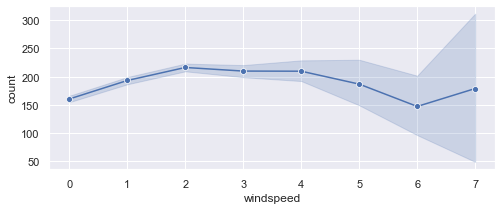

In [66]:
# smooth outliers for large windspeed by binning
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', dtype=None)
data['windspeed'] = est.fit_transform(data['windspeed'].values.reshape(-1, 1))

fig, axs = plt.subplots(figsize=(8, 3))
sns.lineplot(x=data['windspeed'], y=data['count'], marker='o')
plt.show()

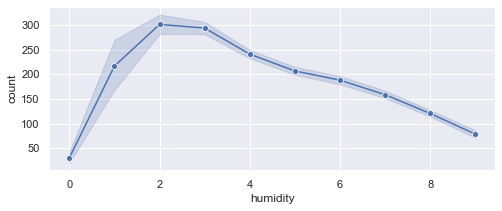

In [67]:
# smooth outliers for small humidity by binning
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
data['humidity'] = est.fit_transform(data['humidity'].values.reshape(-1, 1))

fig, axs = plt.subplots(figsize=(8, 3))
sns.lineplot(x=data['humidity'], y=data['count'], marker='o')
plt.show()

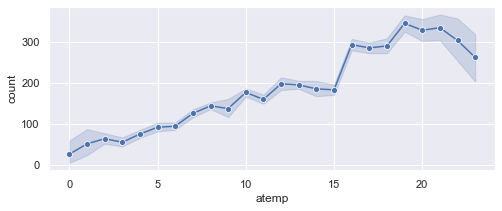

In [68]:
# slightly smooth and encode atemp
est = KBinsDiscretizer(n_bins=24, encode='ordinal', strategy='uniform')
data['atemp'] = est.fit_transform(data['atemp'].values.reshape(-1, 1))

fig, axs = plt.subplots(figsize=(8, 3))
sns.lineplot(x=data['atemp'], y=data['count'], marker='o')
plt.show()

In [69]:
# split features and target values
X = data.drop('count', axis=1)
y = np.log1p(data['count']) #+1 log to not get -inf values


In [70]:
# build preprocessing pipeline
catagorical_cols = ['year', 'month', 'hour', 'weather', 'workingday', 'season']
numerical_cols = ['atemp', 'humidity', 'windspeed']

preprocessor = ColumnTransformer([
    ("minmax", MinMaxScaler(), numerical_cols),
    ("onehot", OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore"), catagorical_cols)
], remainder='passthrough')

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    # ("classifier", LinearRegression())
])

X = pipe.fit_transform(X)

In [71]:
# # put the nparray back into dataframe
# scaler_names_out = pipe['preprocessor'].transformers_[0][1].feature_names_in_
# categorical_names_out = pipe['preprocessor'].transformers_[1][1].get_feature_names_out()
# total_cols_out = np.concatenate((scaler_names_out, categorical_names_out), axis=None)
# X = pd.DataFrame(X, columns=total_cols_out) 

## 3. Model

In [72]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
def calculate_adj_r2(y_pred, y_test, X_train):
    r2 = metrics.r2_score(y_test, y_pred)
    n = len(y_test)# nr. of rows in training data
    p = X_train.shape[1]# nr. of indep varaibles
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2


### 3.1 Linear Regression

In [74]:
# train model
regressor = LinearRegression(fit_intercept=True, n_jobs=-1)
regressor.fit(X_train, y_train)
#predict results
y_pred = regressor.predict(X_test)

In [75]:
# check different scores
print(f'Metrics of simple linear regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of simple linear regression:
MSE: 0.35675432634232696
MAE: 0.4438566500578697
R2: 0.8276
Adjusted R2: 0.8239


### 3.2 Polynomial Linear Regression

In [76]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2, include_bias=False) # we put intercept in linear regression
X_poly = poly_reg.fit_transform(X)

# train model
regressor = LinearRegression(fit_intercept=True, n_jobs=-1)
regressor.fit(X_train, y_train)
#predict results
y_pred = regressor.predict(X_test)

print(f'The coefficients of polynomial model are {regressor.coef_}')


The coefficients of polynomial model are [ 9.19318188e-01 -2.97353873e-01 -1.80643299e-01  4.76206371e-01
  1.75966786e-01  2.84804388e-01  4.90785902e+09  4.90785902e+09
  4.90785902e+09 -2.65338565e+11 -2.65338565e+11 -2.65338565e+11
 -9.49415788e+10 -9.49415788e+10 -9.49415788e+10 -5.94138536e-01
 -1.11071251e+00 -1.57412289e+00 -1.88268585e+00 -9.31378299e-01
  2.58718938e-01  1.22874810e+00  1.88261581e+00  1.55274496e+00
  1.21891163e+00  1.34806695e+00  1.54244507e+00  1.51922495e+00
  1.44097961e+00  1.47791677e+00  1.74038355e+00  2.15489058e+00
  2.07663447e+00  1.77988040e+00  1.48370652e+00  1.21069653e+00
  9.65952551e-01  5.68848255e-01 -5.62471667e-02 -5.64357357e-01
 -1.60715351e-01 -6.15733399e-02 -4.90785901e+09  2.65338565e+11
  9.49415788e+10]


In [77]:
# check different scores
print(f'Metrics of polynomial linear regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of polynomial linear regression:
MSE: 0.35675432634232696
MAE: 0.4438566500578697
R2: 0.8276
Adjusted R2: 0.8239


### 3.3. SVR

In [78]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()

X_trans = sc_X.fit_transform(X)
y_trans = sc_y.fit_transform(y.values.reshape(-1, 1))
y_trans = np.ravel(y_trans)

# split transformed data into train and test set
X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(X_trans, y_trans, test_size=0.20, random_state=0)

# train the model
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_trans_train, y_trans_train)

# re-scale the data back
y_pred = regressor.predict(X_trans_test) # this is not inverse tranformed yet
#y_pred = y_pred.reshape(-1,1)
# now we go back
#y_pred = sc_y.inverse_transform(y_pred)

In [79]:
print(f'Metrics of SVR:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_trans_test, y_pred):4}\nR2: {metrics.r2_score(y_trans_test, y_pred):.4}\nAdjusted R2: {calculate_adj_r2(y_pred, y_trans_test, X_trans_train):.4}')

Metrics of SVR:
MSE: 21.32670550261632
MAE: 0.1648782027508024
R2: 0.9424
Adjusted R2: 0.9412


### 3.4 Decision Tree Regression

In [80]:
# no feature scaling needed 
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(f'Metrics of decision tree regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of decision tree regression:
MSE: 0.33610758758939835
MAE: 0.37686182402276885
R2: 0.8375
Adjusted R2: 0.8341


### 3.5 Random Forest Regression

In [81]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test) 

print(f'Metrics of random forest regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of random forest regression:
MSE: 0.2043394031000702
MAE: 0.3159180353532709
R2: 0.9012
Adjusted R2: 0.8991


### 3.5 Random Forest Regression with RandomizedSearchCV

In [82]:
regressor = RandomForestRegressor(random_state=0)
# use CV and train on whole data set without splitting
saved_params = {'ccp_alpha': 1.3261564062002016, 'max_depth': 11, 'max_features': 5,
                'n_estimators': 31} # kaggle: 0.71

if len(saved_params) == 0:
    regressor = regressor
    # Randomized Search of hyperparams
    distributions = dict(ccp_alpha=uniform(loc=0, scale=2), max_depth=list(range(1,25,1)),
                        n_estimators=list(range(1,60,1)), max_features=list(range(1,25,1)))

    clf = RandomizedSearchCV(regressor, distributions, n_iter= 200, scoring='neg_root_mean_squared_error',
                            cv=5, verbose=1, return_train_score=True, random_state=0)

    search = clf.fit(X, y)
    best_accuracy = search.best_score_
    best_parameters = search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    saved_params = best_parameters

regressor = RandomForestRegressor(**saved_params)
regressor.fit(X,y)
y_pred = regressor.predict(X_test) # this is not inverse tranformed yet

print(f'Metrics of decision tree regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of decision tree regression:
MSE: 2.068835444989233
MAE: 1.167197117169671
R2: -2.392e-05
Adjusted R2: -0.02113


### 3.6 XGBoost with RandomizedSearchCV

In [83]:
# use CV and train on whole data set without splitting
saved_params = {'booster': 'gbtree', 'learning_rate': 0.03865816963989605, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 42} #-0.44
#saved_params = {'booster': 'gbtree', 'gamma': 0.44458728781130075, 'learning_rate': 0.1008306799199662, 'max_depth': 8, 'min_child_weight': 12, 'n_estimators': 14, 'reg_alpha': 0.40430652630881414, 'reg_lambda': 2.6860353417578513} # -44%
saved_params = {'booster': 'dart', 'learning_rate': 0.18466786928515325, 'max_depth': 24, 'min_child_weight': 21, 'n_estimators': 52} #-1.44%, for smoothed data and logy
saved_params = {'booster': 'dart', 'learning_rate': 0.22758468729670714, 'max_depth': 11, 'min_child_weight': 20, 'n_estimators': 152}

if len(saved_params) == 0:
    regressor = XGBRegressor(verbosity=1)
    # Randomized Search of hyperparams
    distributions = dict(learning_rate=uniform(loc=0, scale=0.3),
                        #gamma=uniform(loc=0, scale=1),
                        n_estimators=list(range(1,500,1)),
                        max_depth=list(range(1,50,1)),
                        booster=['gbtree', 'dart'],
                        min_child_weight=list(range(0,25,1)),
                        #reg_alpha=uniform(loc=0, scale=1),
                        #reg_lambda=uniform(loc=0, scale=3),
    )

    clf = RandomizedSearchCV(regressor, distributions, n_iter= 100, scoring='neg_mean_squared_log_error',
                            cv=5, verbose=1, return_train_score=False, random_state=0, n_jobs=5)

    search = clf.fit(X, y)
    best_accuracy = search.best_score_
    best_parameters = search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    saved_params = best_parameters

In [84]:
## XGboost with saved params
regressor = XGBRegressor(**saved_params)
regressor.fit(X, y)
# check cross-validation
results = cross_val_score(regressor, X, y, cv=5, verbose=4, scoring='neg_mean_squared_log_error')
print(results.mean())
print(f'CV mean RMSLE: {np.sqrt(-results.mean())}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.027) total time=   4.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................... score: (test=-0.008) total time=   4.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.5s remaining:    0.0s


[CV] END ............................... score: (test=-0.017) total time=   4.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s


[CV] END ............................... score: (test=-0.008) total time=   5.1s
[CV] END ............................... score: (test=-0.009) total time=   4.7s
-0.013617261694896032
CV mean RMSLE: 0.1166930233342852


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.1s finished


### 3.7 LightGBM with RandomizedSearchCV

In [208]:
import lightgbm as lgb

# use CV and train on whole data set without splitting
saved_params = {'booster': 'gbtree', 'learning_rate': 0.03865816963989605, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 42} #-0.44
#saved_params = {'booster': 'gbtree', 'gamma': 0.44458728781130075, 'learning_rate': 0.1008306799199662, 'max_depth': 8, 'min_child_weight': 12, 'n_estimators': 14, 'reg_alpha': 0.40430652630881414, 'reg_lambda': 2.6860353417578513} # -44%
saved_params =  {'learning_rate': 0.08601500491211829, 'max_depth': 9, 'n_estimators': 47, 'num_leaves': 36}
saved_params =  {'learning_rate': 0.3196810349409567, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 1567, 'num_leaves': 55}

saved_params =  {}

if len(saved_params) == 0:
    regressor = lgb.LGBMRegressor(random_state=0)    # Randomized Search of hyperparams
    distributions = dict(learning_rate=uniform(loc=0, scale=1),
                        num_leaves=list(range(1,150,1)),
                        n_estimators=list(range(1,2000,1)),
                        max_depth=list(range(1,100,1)),
                        min_child_weight=list(range(0,20,1)),
                        #reg_alpha=uniform(loc=0, scale=1),
                        #reg_lambda=uniform(loc=0, scale=3),
    )

    clf = RandomizedSearchCV(regressor, distributions, n_iter= 500, scoring='neg_mean_squared_log_error',
                            cv=5, verbose=1, return_train_score=False, random_state=0)

    search = clf.fit(X, y)
    best_accuracy = search.best_score_
    best_parameters = search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    saved_params = best_parameters

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


c:\Users\Me\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Me\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Me\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "c:\Users\Me\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Users\Me\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 521, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

  warnings.warn(
c:\Users\Me\anaconda3\lib\site-packages\sklearn\model_select

Best Accuracy: -0.99 %
Best Parameters: {'learning_rate': 0.6147364965366232, 'max_depth': 2, 'min_child_weight': 8, 'n_estimators': 1281, 'num_leaves': 140}


c:\Users\Me\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
55 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Me\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Me\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\Users\Me\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "c:\Users\Me\anaconda3\lib\site-

In [209]:
## XGboost with saved params
regressor =  lgb.LGBMRegressor(**saved_params)
regressor.fit(X, y)
# check cross-validation
results = cross_val_score(regressor, X, y, cv=5, verbose=4, scoring='neg_mean_squared_log_error')
results.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.019) total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-0.007) total time=   0.1s
[CV] END ............................... score: (test=-0.010) total time=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-0.007) total time=   0.1s
[CV] END ............................... score: (test=-0.006) total time=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


-0.009869289561233055

In [121]:
df = pd.DataFrame(clf.cv_results_)
df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
360,0.305139,0.005641,0.022717,0.003413,0.280776,2,19,2298,38,"{'learning_rate': 0.2807755221638232, 'max_dep...",-0.022362,-0.007560,-0.011938,-0.006862,-0.005909,-0.010926,0.006080,1
329,0.206336,0.025439,0.016567,0.001021,0.278441,2,15,1625,60,"{'learning_rate': 0.27844088558956026, 'max_de...",-0.022198,-0.007883,-0.011821,-0.006648,-0.006192,-0.010948,0.005964,2
293,0.316846,0.023891,0.026387,0.005197,0.317181,2,14,2128,114,"{'learning_rate': 0.31718099692554946, 'max_de...",-0.022145,-0.007543,-0.012405,-0.006753,-0.005896,-0.010949,0.006037,3
266,0.310397,0.043368,0.021725,0.001944,0.303889,2,8,2192,120,"{'learning_rate': 0.30388924442708914, 'max_de...",-0.022480,-0.007511,-0.012517,-0.006523,-0.005713,-0.010949,0.006233,4
255,0.393725,0.079143,0.023015,0.001353,0.257185,2,16,2419,143,"{'learning_rate': 0.25718482112069635, 'max_de...",-0.021822,-0.007404,-0.013072,-0.006717,-0.005837,-0.010970,0.005989,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.094339,0.002335,0.008234,0.001316,0.000242,2,2,715,40,"{'learning_rate': 0.00024204438502674062, 'max...",-0.149646,-0.071739,-0.104562,-0.078199,-0.070733,-0.094976,0.029966,496
91,0.002778,0.000397,0.000000,0.000000,0.030232,1,7,596,1,"{'learning_rate': 0.03023194312972443, 'max_de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,497
493,0.002381,0.000371,0.000000,0.000000,0.327993,1,9,2445,1,"{'learning_rate': 0.32799305718612287, 'max_de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,498
348,0.002281,0.000397,0.000000,0.000000,0.08792,2,5,811,1,"{'learning_rate': 0.08792004078365306, 'max_de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,499


In [122]:
# draw histogram of importances of each feature
importances = pd.DataFrame(zip(regressor.feature_importances_,regressor.feature_names_in_), columns=['Importance', 'Feature'])
importances.sort_values(by='Importance', inplace=True, ascending=False)
plt.figure(figsize=(40, 10))
sns.barplot(x='Feature', y='Importance', data=importances)

AttributeError: 'LGBMRegressor' object has no attribute 'feature_names_in_'

## 4. Kaggle Submission on Test Data Set

In [210]:
data_test = pd.read_csv('./data/test.csv', index_col=0, parse_dates=True) # read 1st col as datetimeindex# process columns Ticket, Age, Class
data_test.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012


In [211]:
data_test.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [212]:
print('The test table contains no NaNs')

The test table contains no NaNs


In [213]:
## perform same feature engineering as for the Training Set
# create new feature: year, month, day of the week
data_test['year'] = data_test.index.year
data_test['month'] =  data_test.index.month
data_test['day'] =  data_test.index.dayofweek
data_test['hour'] =  data_test.index.hour

In [214]:
# remove unnecessary features according to the observations above
data_test = data_test.drop(columns=['holiday', 'temp', 'day'], axis=1)

In [215]:
# smooth outliers for large windspeed by binning
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', dtype=None)
data_test['windspeed'] = est.fit_transform(data_test['windspeed'].values.reshape(-1, 1))

In [216]:
# smooth outliers for small humidity by binning
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
data_test['humidity'] = est.fit_transform(data_test['humidity'].values.reshape(-1, 1))

In [217]:
# slightly smooth and encode atemp
est = KBinsDiscretizer(n_bins=24, encode='ordinal', strategy='uniform')
data_test['atemp'] = est.fit_transform(data_test['atemp'].values.reshape(-1, 1))

In [218]:
X_test = pipe.transform(data_test)

In [219]:
# make predictions based on Model chosen in 3.
y_pred_test = regressor.predict(X_test)
y_pred_test = np.expm1(y_pred_test)#convert back from log
y_pred_test= y_pred_test.round()
y_pred_test.shape

(6493,)

In [220]:
y_pred_test

array([13.,  4.,  2., ..., 93., 76., 49.])

In [221]:
id_column = data_test.index

In [222]:
# write titanic kaggle .csv submission
y_pred_column = pd.DataFrame(y_pred_test, id_column, columns=['count'])
y_pred_column.to_csv('./output/solution.csv')